In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
import chart_studio.plotly as py
cf.go_offline()

## Data Collection and Data Manipulation

In [2]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [3]:
fb = get_finance_data('fb')

In [4]:
fb

,Open,High,Low,Close,Volume
Date,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200
...,...,...,...,...,...
2021-10-15,328.679993,329.070007,322.510010,324.760010,21575100
2021-10-18,328.950012,335.890015,327.500000,335.339996,21585000
2021-10-19,339.649994,342.459991,337.279999,339.989990,18786300


In [5]:
fb_close = fb[['Close']]

## Data Visualization

In [6]:
fb_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
fb['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

# Time Series Data

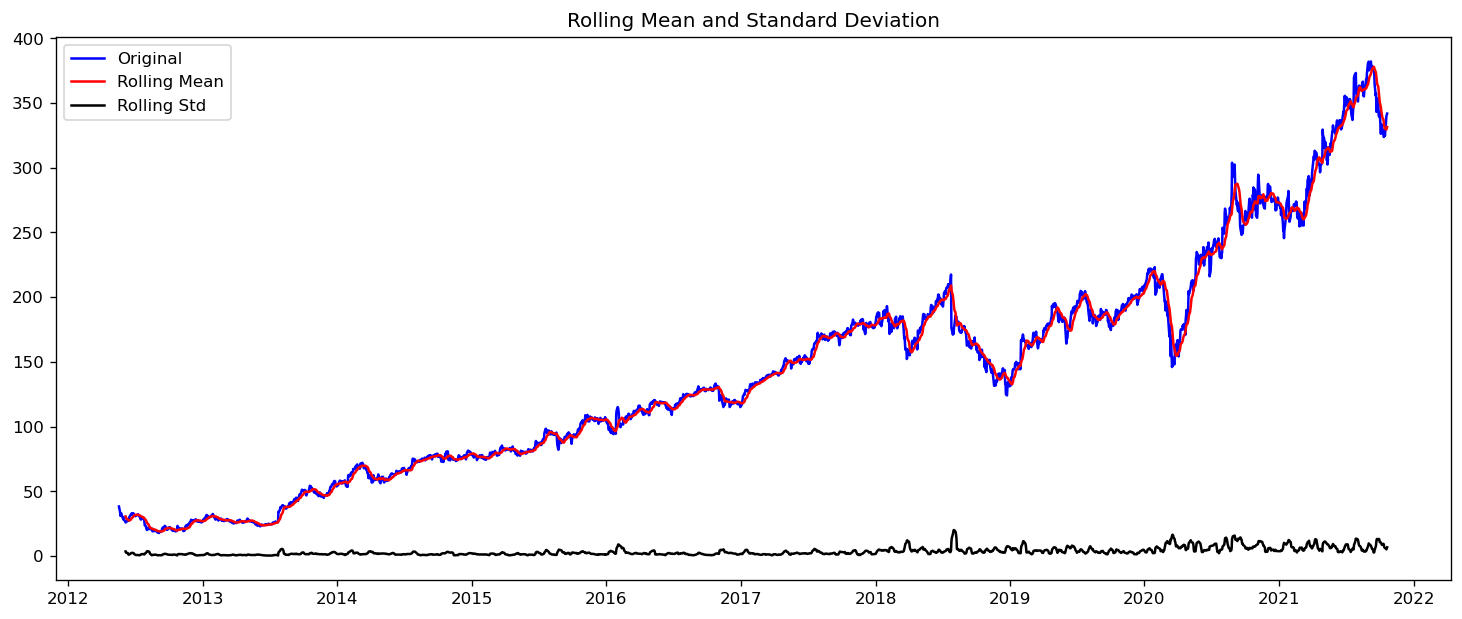

Results of dickey fuller test
Test Statistics                   0.376917
p-value                           0.980611
No. of lags used                 24.000000
Number of observations used    2348.000000
critical value (1%)              -3.433138
critical value (5%)              -2.862772
critical value (10%)             -2.567426
dtype: float64


In [32]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(fb_close)

<Figure size 1800x720 with 0 Axes>

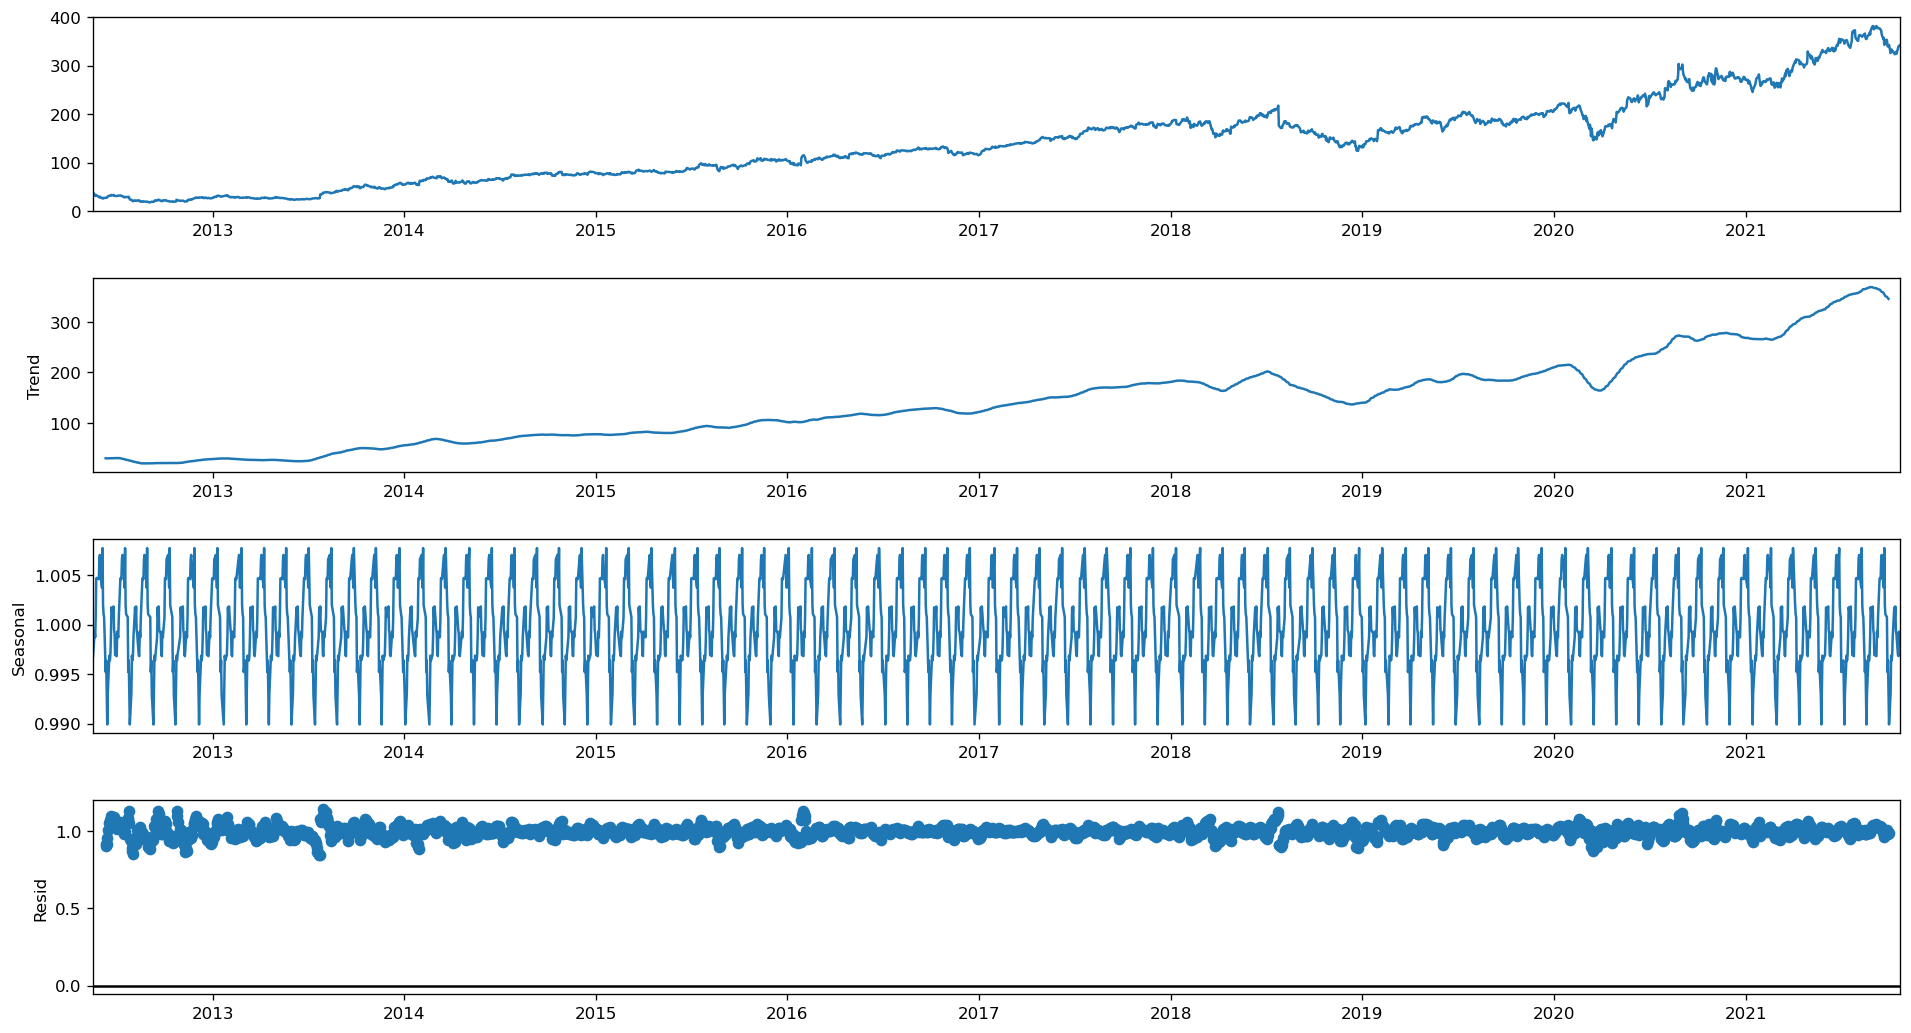

In [33]:
result = seasonal_decompose(fb_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Time Series Data Manipulation

In [8]:
fb_close

,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999
...,...
2021-10-15,324.760010
2021-10-18,335.339996
2021-10-19,339.989990


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(fb_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.376917
p-value: 0.980611


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

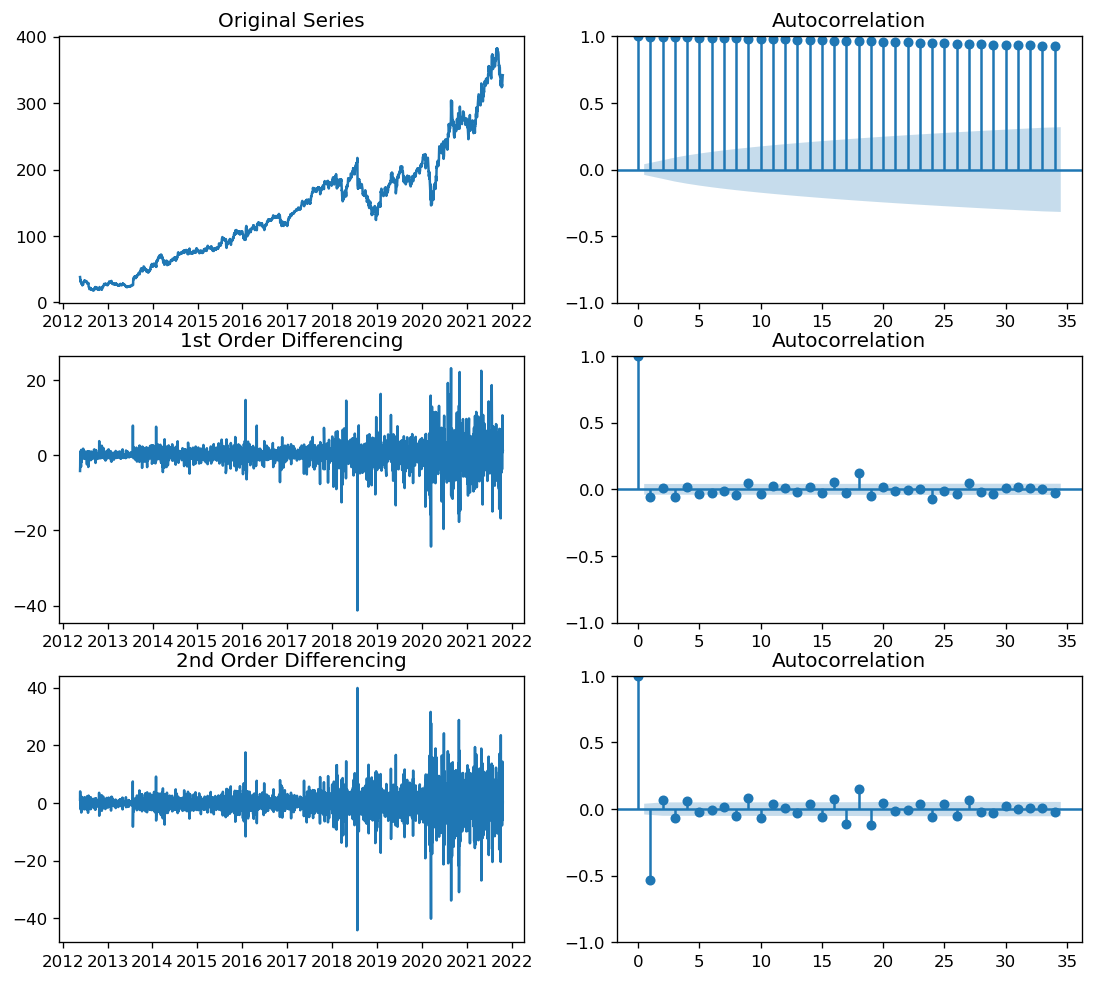

In [10]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(fb_close); axes[0, 0].set_title('Original Series')
plot_acf(fb_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(fb_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(fb_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(fb_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(fb_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



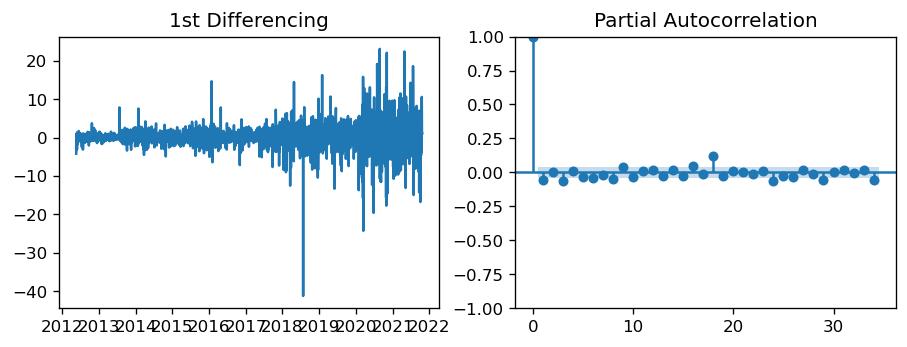

In [11]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(fb_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(fb_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

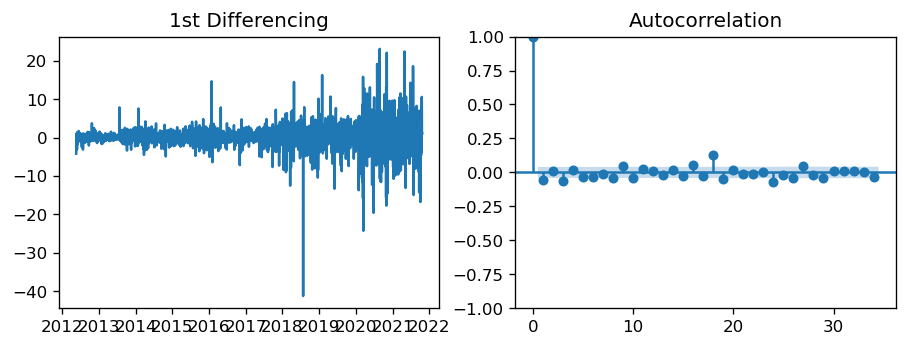

In [12]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(fb_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(fb_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA

## Train-Test Split

In [13]:
n = int(len(fb_close) * 0.80)
train = fb_close[:n]
test = fb_close[n:]

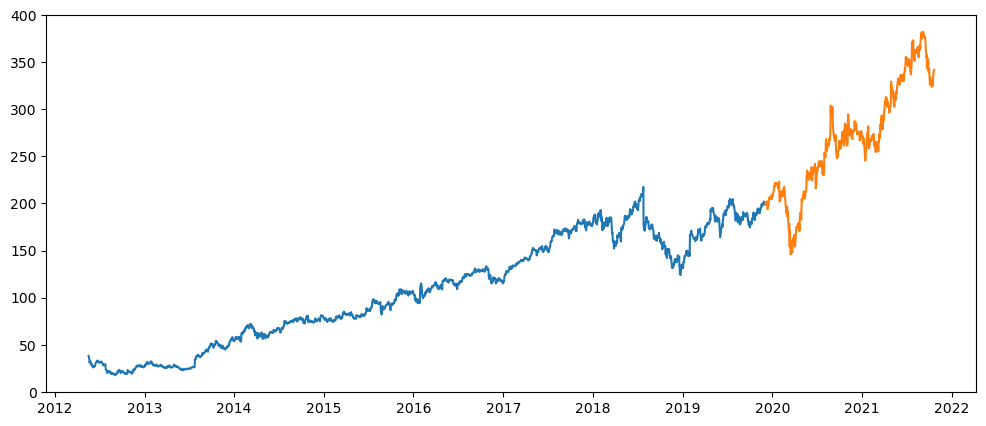

In [14]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [15]:
model = SARIMAX(fb_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2373
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6224.091
Date:                Wed, 27 Oct 2021   AIC                          12454.182
Time:                        14:58:47   BIC                          12471.496
Sample:                             0   HQIC                         12460.485
                               - 2373                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6350      0.092     -6.898      0.000      -0.815      -0.455
ma.L1          0.5823      0.096      6.040      0.000       0.393       0.771
sigma2        11.1349      0.104    107.472      0.0

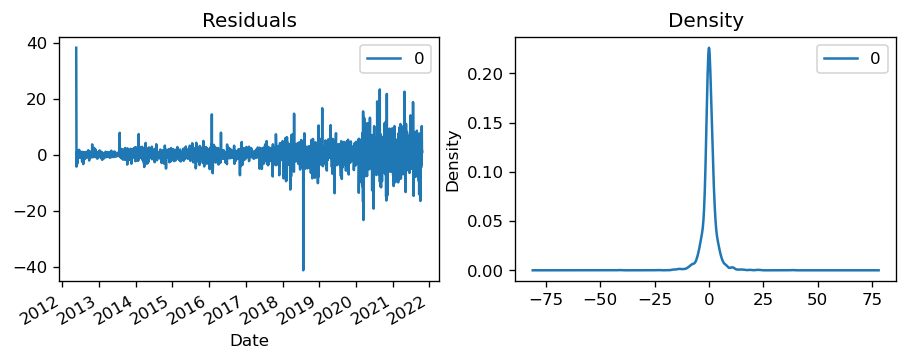

In [16]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [17]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), end=pd.to_datetime('2021-10-21'), dynamic=False)
plt.show()

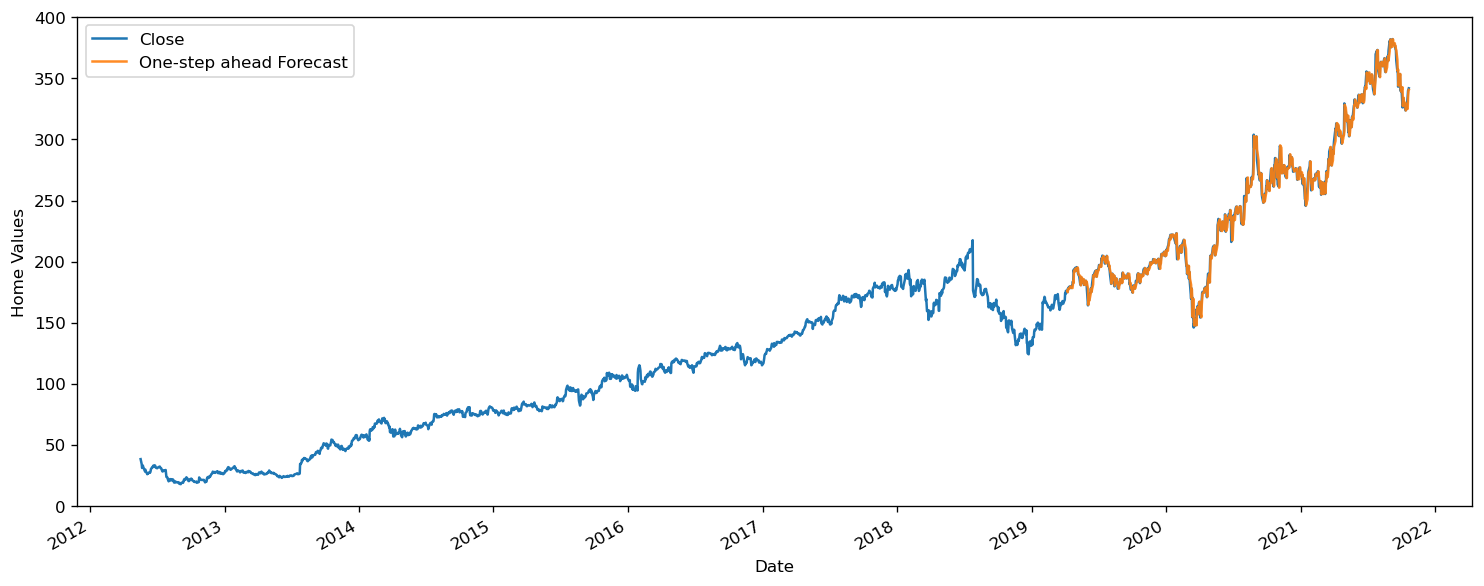

In [18]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = fb_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();

In [19]:
value_forecasted = pred
value_truth = fb_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 5.28


In [35]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(value_truth, value_forecasted)

0.015704449592360295

# PMDARIMA 

In [20]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [21]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [22]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8535.261, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8536.600, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8536.578, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8535.846, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8531.136, Time=1.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8532.764, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8532.781, Time=1.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8538.040, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8538.118, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8533.439, Time=0.42 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 8.419 seconds


In [23]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1898
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4261.568
Date:                Wed, 27 Oct 2021   AIC                           8531.136
Time:                        14:58:57   BIC                           8553.328
Sample:                             0   HQIC                          8539.306
                               - 1898                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0123      0.009      1.368      0.171      -0.005       0.030
ar.L1          0.8559      0.075     11.441      0.000       0.709       1.003
ma.L1         -0.8899      0.067    -13.365      0.0

In [24]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 34.89916598870819
SMAPE: 1.7061926744733635


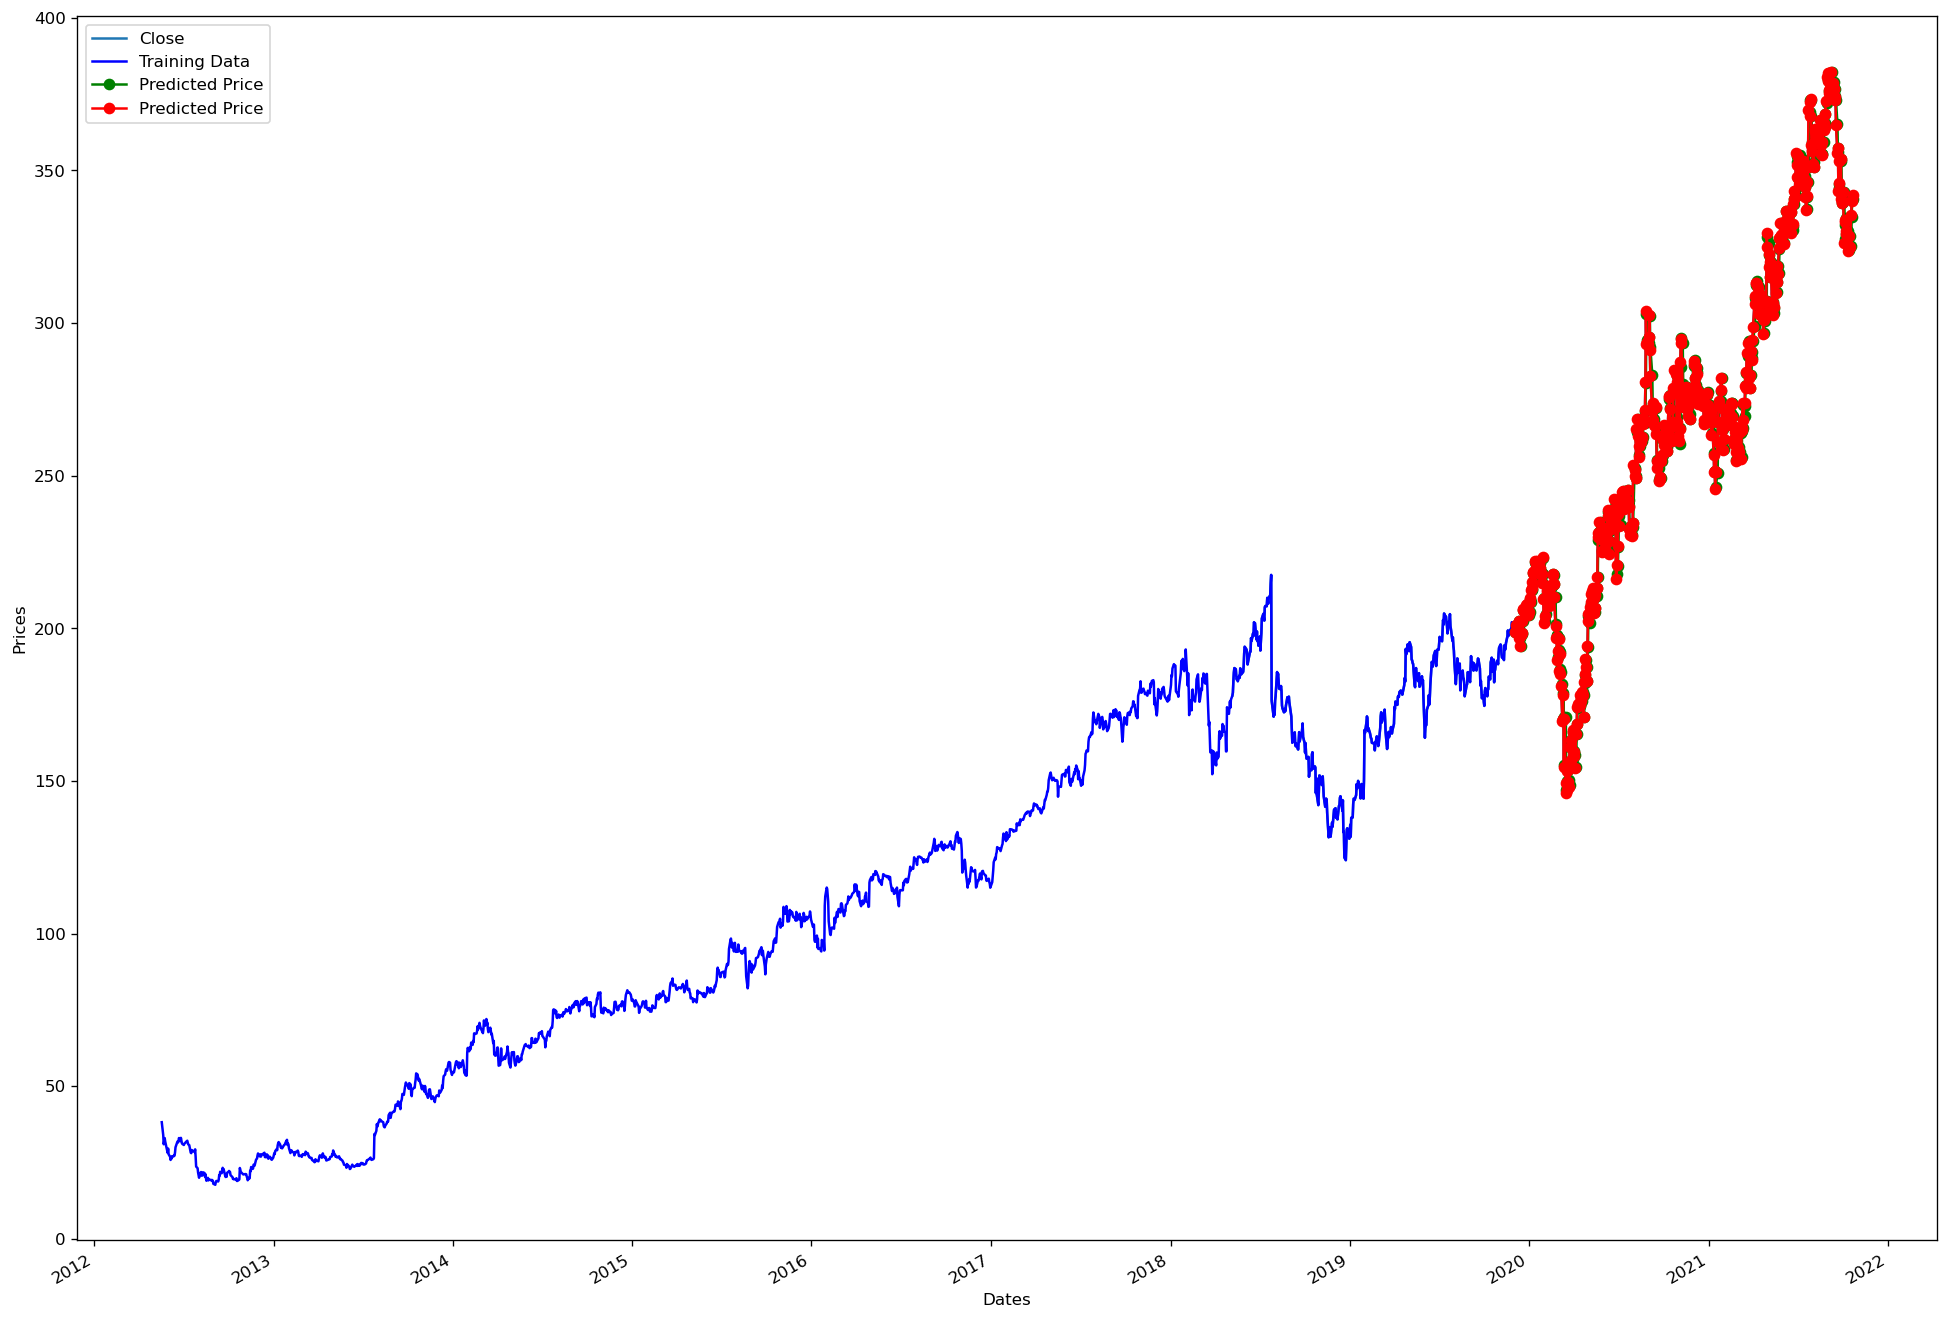

In [25]:
ax = fb_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [26]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(34.89916598870819), 2)))

The Root Mean Squared Error of prediction is 5.91


## SARIMAX PMDARIMA

In [27]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12668.453, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=9209.911, Time=2.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11090.355, Time=1.90 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12710.723, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9722.598, Time=0.39 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8983.243, Time=10.06 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=31.79 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.39 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=12658.735, Time=9.19 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8985.013, Time=16.24 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=8985.020, Time=16.50 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=11092.592, Time=9.57 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=32.90 sec
 ARIMA(1,0,0)(2,1,0)[12]     

In [28]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 43.520767648001566
SMAPE: 1.9727214078115867


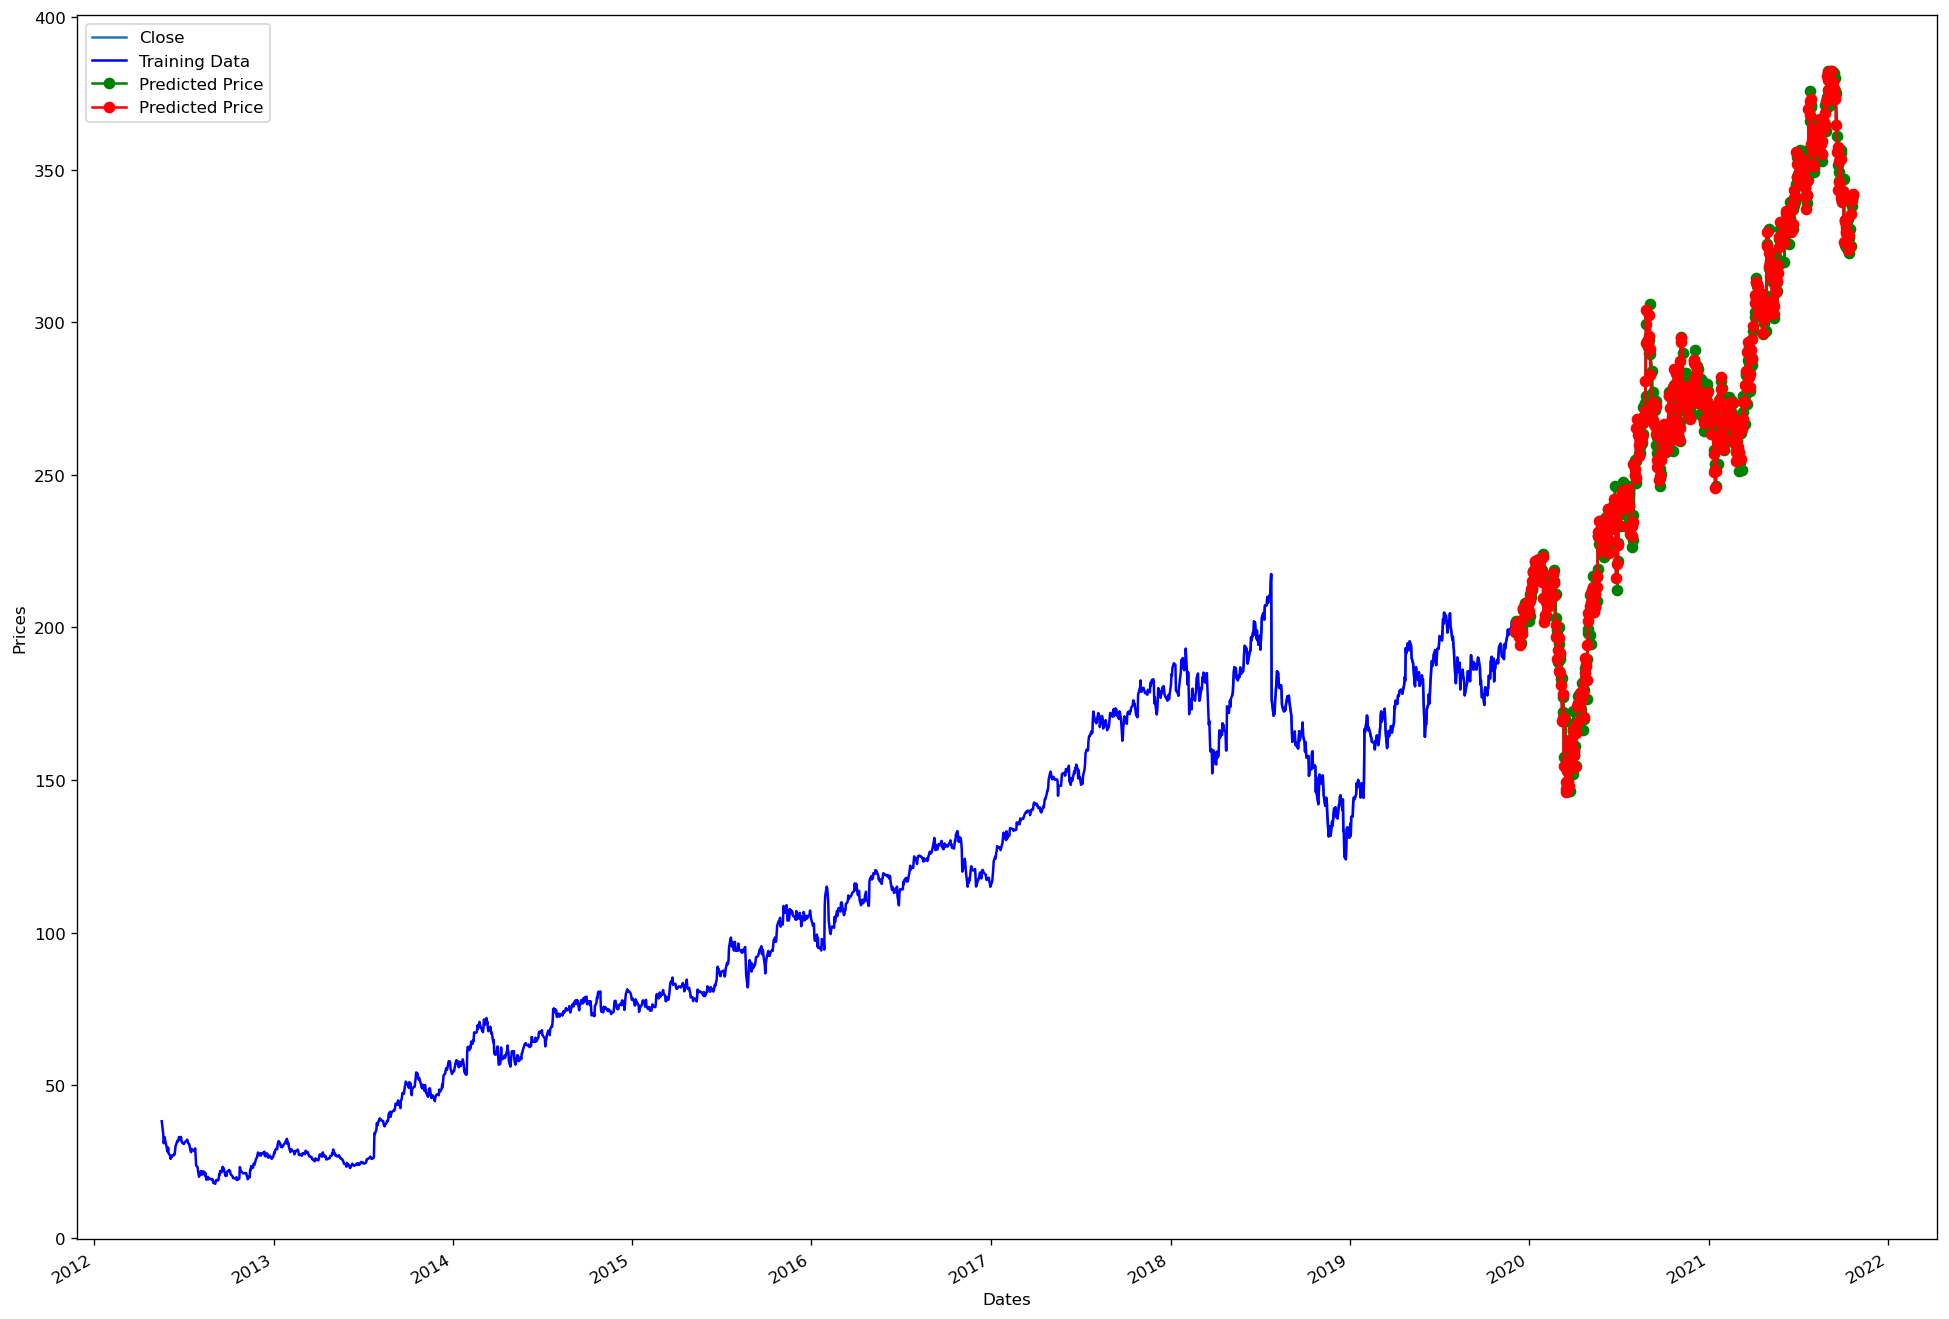

In [29]:
ax = fb_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [31]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(43.520767648001566), 2)))

The Root Mean Squared Error of prediction is 6.6


## FBPROPHET

In [36]:
fb_close =fb[['Close']]

In [37]:
fb = fb_close.reset_index()

In [38]:
fb.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
fb['ds'] = pd.to_datetime(fb['ds'])
fb['y']=fb['y'].astype(float)

In [39]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
df_prophet.fit(fb)

In [40]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
2728,2022-10-12
2729,2022-10-13
2730,2022-10-14
2731,2022-10-15
2732,2022-10-16
2733,2022-10-17
2734,2022-10-18
2735,2022-10-19
2736,2022-10-20
2737,2022-10-21


In [41]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [42]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2733,2022-10-17,450.968673,365.542310,529.843040
2734,2022-10-18,451.740888,367.495878,529.375843
2735,2022-10-19,452.306674,367.973212,530.688292
2736,2022-10-20,452.908371,368.155116,534.746792
2737,2022-10-21,453.482571,368.941852,535.717886


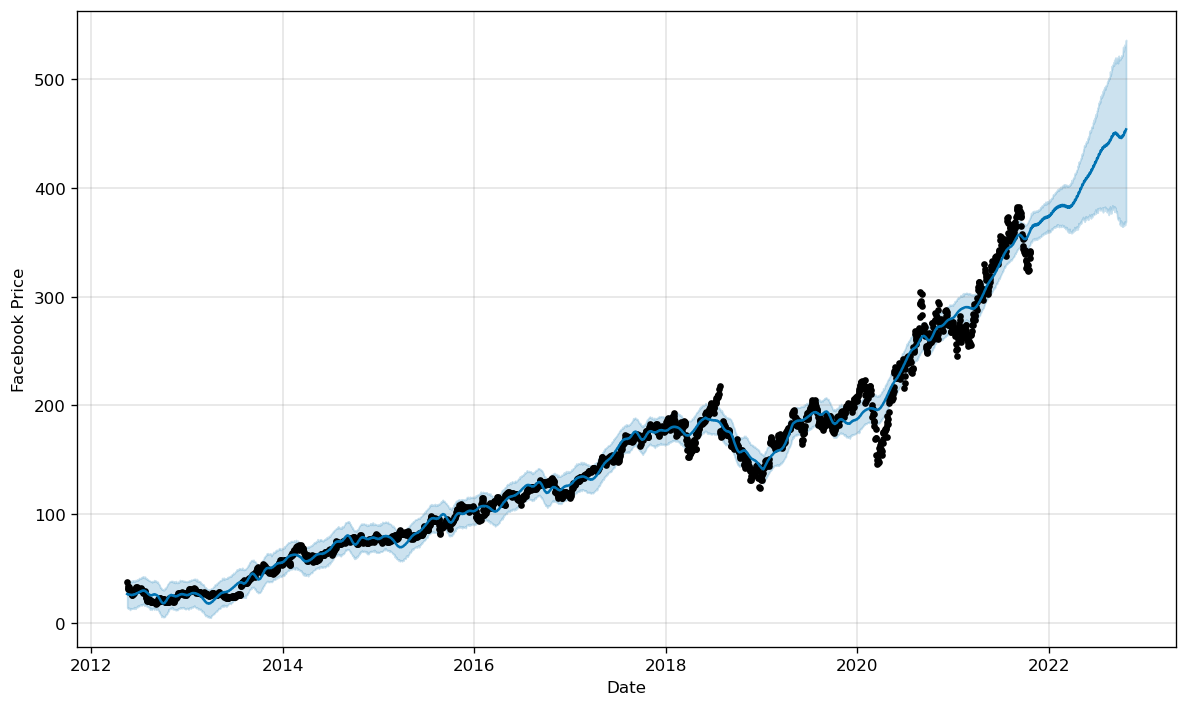

In [43]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Facebook Price');

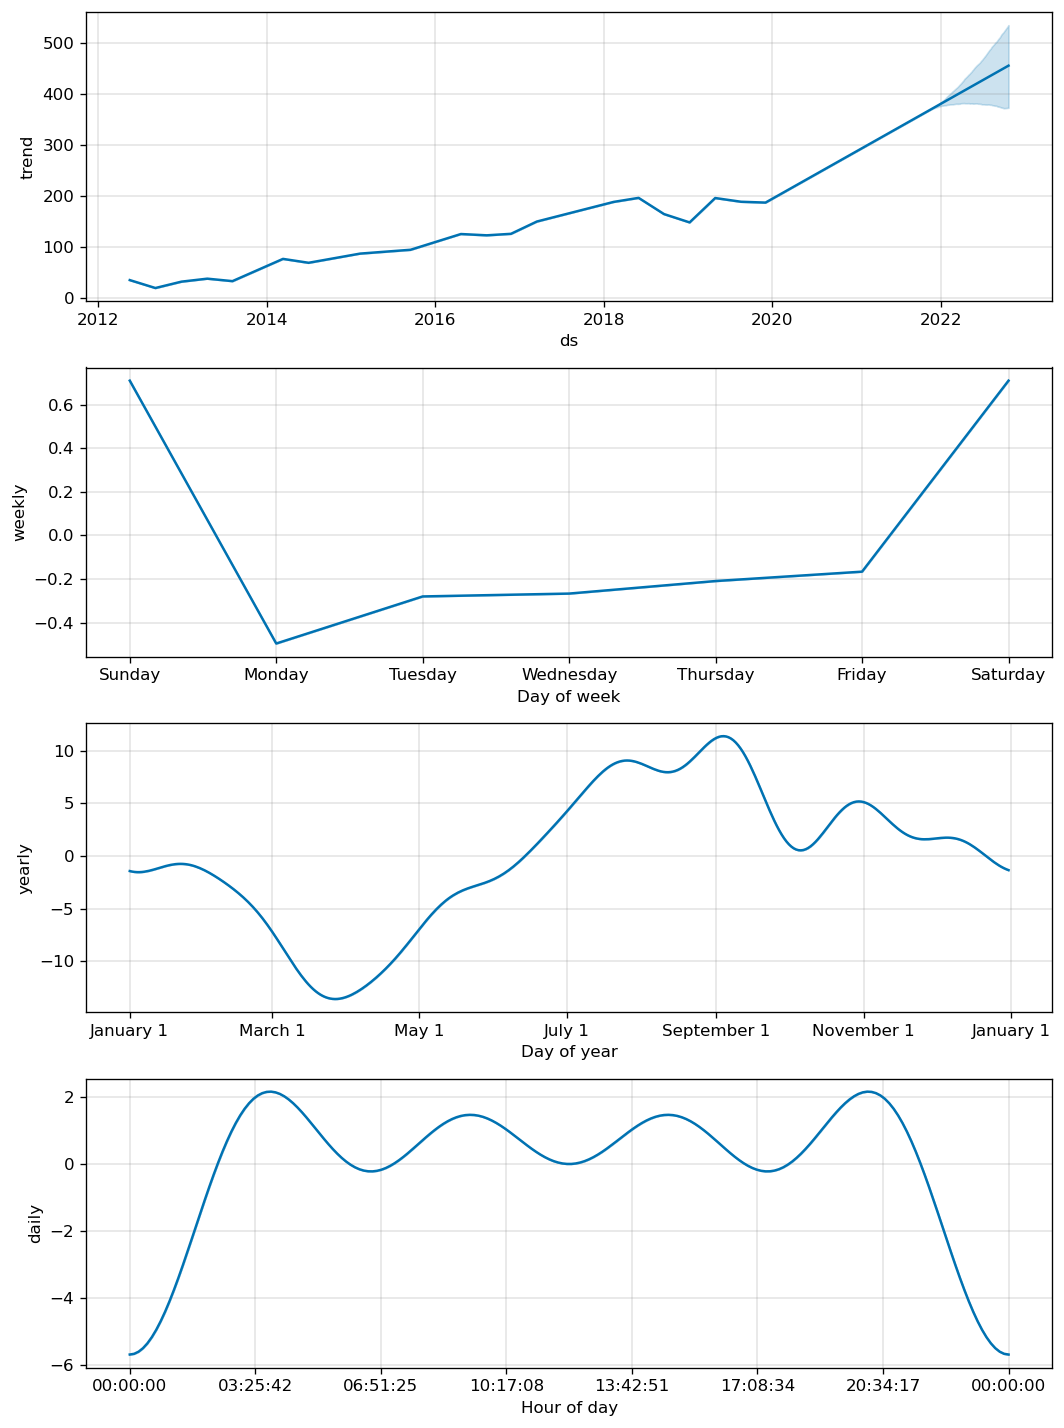

In [44]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [45]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 11 forecasts with cutoffs between 2015-10-23 00:00:00 and 2020-10-21 00:00:00
100%|██████████| 11/11 [02:07<00:00, 11.62s/it]


In [46]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,446.956366,21.141343,16.782739,0.100047,0.084057,0.100382,0.170290
1,37 days 00:00:00,452.839188,21.280019,16.876234,0.100815,0.084057,0.100991,0.168478
2,37 days 12:00:00,450.775238,21.231468,16.826891,0.100518,0.084057,0.100758,0.170290
3,38 days 00:00:00,456.549614,21.367022,16.925750,0.101537,0.084057,0.101743,0.165942
4,38 days 12:00:00,451.479763,21.248053,16.834376,0.101149,0.082771,0.101398,0.161594


## Result

The ARIMA model performed the best with the lowest rmse